# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.053385,False,-2.382253
1,-1.196332,False,-3.562012
2,-1.356910,False,-0.898313
3,-0.401276,False,-1.268986
4,-0.836962,True,2.295690
...,...,...,...
995,-1.392931,False,-3.240571
996,-1.624648,False,-1.489604
997,-0.364723,False,-0.714318
998,-1.764083,False,-1.885944


<AxesSubplot: xlabel='v0'>

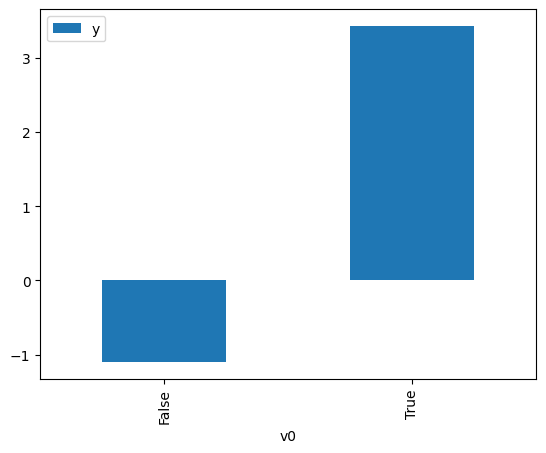

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

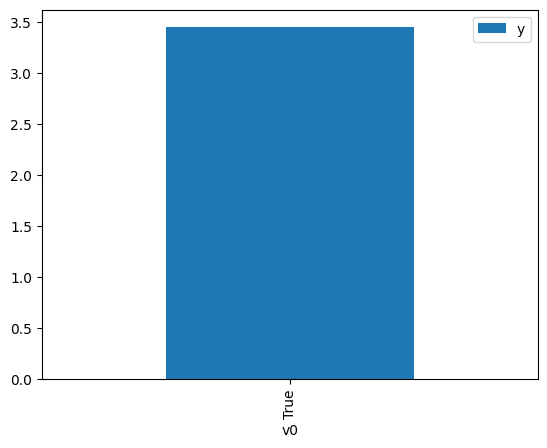

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.313333,False,3.742422,0.078189,12.789473
1,0.072448,False,-0.122709,0.457751,2.184591
2,-0.094551,False,0.740250,0.534904,1.869496
3,-0.744022,False,-1.579482,0.792901,1.261192
4,-2.435087,False,-5.113836,0.988726,1.011402
...,...,...,...,...,...
995,0.585205,False,-0.347736,0.246216,4.061474
996,-0.099367,False,-1.692048,0.537122,1.861775
997,0.495530,False,2.009518,0.278314,3.593066
998,-0.739276,False,-1.238139,0.791454,1.263498


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.226711,True,5.635631,0.611840,1.634414
1,-2.040833,True,0.659051,0.023115,43.261236
2,-1.703515,True,2.348734,0.042320,23.629221
3,0.236088,True,6.840954,0.615956,1.623492
4,-1.130759,True,2.119977,0.113182,8.835316
...,...,...,...,...,...
995,-0.670761,True,3.996074,0.230261,4.342901
996,0.391049,True,4.729219,0.681216,1.467962
997,-1.004811,True,3.447723,0.138785,7.205376
998,-1.723500,True,1.038397,0.040846,24.482360


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6760.
Date:                Tue, 16 May 2023   Prob (F-statistic):                        0.00
Time:                        15:33:57   Log-Likelihood:                         -1405.0
No. Observations:                1000   AIC:                                      2814.
Df Residuals:                     998   BIC:                                      2824.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8807      0.026     72.060      0.000       1.829       1.932
x2             4.8472      0.056     86.410      0.000       4.737       4.957
==============================================================================
Omnibus:                        0.348   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.840   Jarque-Bera (JB):                0.240
Skew:                           0.010   Prob(JB):                        0.887
Kurtosis:                       3.073   Cond. No.                         2.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""